<a href="https://colab.research.google.com/github/VAEs-Tutorial/paper/blob/master/VAE_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd
import tensorflow_probability as tfp
ds = tfp.distributions
TRAIN_BUF=60000
BATCH_SIZE=64
TEST_BUF=10000
DIMS = (28,28,1)
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)
# load dataset
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

# split dataset
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype(
    "float32"
) / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE)
)
class VAEGAN(tf.keras.Model):
    """a VAEGAN class for tensorflow
    
    Extends:
        tf.keras.Model
    """

    def __init__(self, **kwargs):
        super(VAEGAN, self).__init__()
        self.__dict__.update(kwargs)

        self.enc = tf.keras.Sequential(self.enc)
        self.dec = tf.keras.Sequential(self.dec)
        inputs, disc_l, outputs = self.vae_disc_function()
        self.disc = tf.keras.Model(inputs=[inputs], outputs=[outputs, disc_l])

        self.enc_optimizer = tf.keras.optimizers.Adam(self.lr_base_gen, beta_1=0.5)
        self.dec_optimizer = tf.keras.optimizers.Adam(self.lr_base_gen, beta_1=0.5)
        self.disc_optimizer = tf.keras.optimizers.Adam(self.get_lr_d, beta_1=0.5)

    def encode(self, x):
        mu, sigma = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return mu, sigma

    def dist_encode(self, x):
        mu, sigma = self.encode(x)
        return ds.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

    def get_lr_d(self):
        return self.lr_base_disc * self.D_prop

    def decode(self, z):
        return self.dec(z)

    def discriminate(self, x):
        return self.disc(x)

    def reconstruct(self, x):
        mean, _ = self.encode(x)
        return self.decode(mean)

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    # @tf.function
    def compute_loss(self, x):
        # pass through network
        q_z = self.dist_encode(x)
        z = q_z.sample()
        p_z = ds.MultivariateNormalDiag(
            loc=[0.0] * z.shape[-1], scale_diag=[1.0] * z.shape[-1]
        )
        xg = self.decode(z)
        z_samp = tf.random.normal([x.shape[0], 1, 1, z.shape[-1]])
        xg_samp = self.decode(z_samp)
        d_xg, ld_xg = self.discriminate(xg)
        d_x, ld_x = self.discriminate(x)
        d_xg_samp, ld_xg_samp = self.discriminate(xg_samp)

        # GAN losses
        disc_real_loss = gan_loss(logits=d_x, is_real=True)
        disc_fake_loss = gan_loss(logits=d_xg_samp, is_real=False)
        gen_fake_loss = gan_loss(logits=d_xg_samp, is_real=True)

        discrim_layer_recon_loss = (
            tf.reduce_mean(tf.reduce_mean(tf.math.square(ld_x - ld_xg), axis=0))
            / self.recon_loss_div
        )

        self.D_prop = sigmoid(
            disc_fake_loss - gen_fake_loss, shift=0.0, mult=self.sig_mult
        )

        kl_div = ds.kl_divergence(q_z, p_z)
        latent_loss = tf.reduce_mean(tf.maximum(kl_div, 0)) / self.latent_loss_div

        return (
            self.D_prop,
            latent_loss,
            discrim_layer_recon_loss,
            gen_fake_loss,
            disc_fake_loss,
            disc_real_loss,
        )

    # @tf.function
    def compute_gradients(self, x):
        with tf.GradientTape() as enc_tape, tf.GradientTape() as dec_tape, tf.GradientTape() as disc_tape:
            (
                _,
                latent_loss,
                discrim_layer_recon_loss,
                gen_fake_loss,
                disc_fake_loss,
                disc_real_loss,
            ) = self.compute_loss(x)

            enc_loss = latent_loss + discrim_layer_recon_loss
            dec_loss = gen_fake_loss + discrim_layer_recon_loss
            disc_loss = disc_fake_loss + disc_real_loss

        enc_gradients = enc_tape.gradient(enc_loss, self.enc.trainable_variables)
        dec_gradients = dec_tape.gradient(dec_loss, self.dec.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return enc_gradients, dec_gradients, disc_gradients

    @tf.function
    def apply_gradients(self, enc_gradients, dec_gradients, disc_gradients):
        self.enc_optimizer.apply_gradients(
            zip(enc_gradients, self.enc.trainable_variables)
        )
        self.dec_optimizer.apply_gradients(
            zip(dec_gradients, self.dec.trainable_variables)
        )
        self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc.trainable_variables)
        )

    def train(self, x):
        enc_gradients, dec_gradients, disc_gradients = self.compute_gradients(x)
        self.apply_gradients(enc_gradients, dec_gradients, disc_gradients)


def gan_loss(logits, is_real=True):
    """Computes standard gan loss between logits and labels
                
        Arguments:
            logits {[type]} -- output of discriminator
        
        Keyword Arguments:
            isreal {bool} -- whether labels should be 0 (fake) or 1 (real) (default: {True})
        """
    if is_real:
        labels = tf.ones_like(logits)
    else:
        labels = tf.zeros_like(logits)

    return tf.compat.v1.losses.sigmoid_cross_entropy(
        multi_class_labels=labels, logits=logits
    )


def sigmoid(x, shift=0.0, mult=20):
    """ squashes a value with a sigmoid
    """
    return tf.constant(1.0) / (
        tf.constant(1.0) + tf.exp(-tf.constant(1.0) * (x * mult))
    )
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


11493376/11490434 [==============================] - 0s 0us/step


In [2]:
N_Z = 128

In [3]:
encoder = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=N_Z*2),
]

decoder = [
    tf.keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
]

def vaegan_discrim():
    inputs = tf.keras.layers.Input(shape=(28, 28, 1))
    conv1 = tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation="relu"
            )(inputs)
    conv2 = tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation="relu"
            )(conv1)
    flatten = tf.keras.layers.Flatten()(conv2)
    lastlayer = tf.keras.layers.Dense(units=512, activation="relu")(flatten)
    outputs = tf.keras.layers.Dense(units=1, activation = None)(lastlayer)
    return inputs, lastlayer, outputs

In [4]:

# the unet function 
gen_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(1e-3)
    
# model
model = VAEGAN(
    enc = encoder,
    dec = decoder,
    vae_disc_function = vaegan_discrim,
    lr_base_gen = 1e-3, # 
    lr_base_disc = 1e-4, # the discriminator's job is easier than the generators so make the learning rate lower
    latent_loss_div=1, # this variable will depend on your dataset - choose a number that will bring your latent loss to ~1-10
    sig_mult = 10, # how binary the discriminator's learning rate is shifted (we squash it with a sigmoid)
    recon_loss_div = .001, # this variable will depend on your dataset - choose a number that will bring your latent loss to ~1-10
)

In [5]:
# exampled data for plotting results
example_data = next(iter(train_dataset))
model.train(example_data)
def plot_reconstruction(model, example_data, nex=8, zm=2):

    example_data_reconstructed = model.reconstruct(example_data)
    samples = model.decode(tf.random.normal(shape=(BATCH_SIZE, N_Z)))
    fig, axs = plt.subplots(ncols=nex, nrows=3, figsize=(zm * nex, zm * 3))
    for axi, (dat, lab) in enumerate(
        zip(
            [example_data, example_data_reconstructed, samples],
            ["data", "data recon", "samples"],
        )
    ):
        for ex in range(nex):
            axs[axi, ex].matshow(
                dat.numpy()[ex].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
            )
            axs[axi, ex].axes.get_xaxis().set_ticks([])
            axs[axi, ex].axes.get_yaxis().set_ticks([])
        axs[axi, 0].set_ylabel(lab)

    plt.show()
    
def plot_losses(losses):
    fig, axs =plt.subplots(ncols = 4, nrows = 1, figsize= (16,4))
    axs[0].plot(losses.latent_loss.values, label = 'latent_loss')
    axs[1].plot(losses.discrim_layer_recon_loss.values, label = 'discrim_layer_recon_loss')
    axs[2].plot(losses.disc_real_loss.values, label = 'disc_real_loss')
    axs[2].plot(losses.disc_fake_loss.values, label = 'disc_fake_loss')
    axs[2].plot(losses.gen_fake_loss.values, label = 'gen_fake_loss')
    axs[3].plot(losses.d_prop.values, label = 'd_prop')

    for ax in axs.flatten():
        ax.legend()
    plt.show()

In [6]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns=[
    'd_prop',
    'latent_loss',
    'discrim_layer_recon_loss',
    'gen_fake_loss',
    'disc_fake_loss',
    'disc_real_loss',
])

Epoch: 9


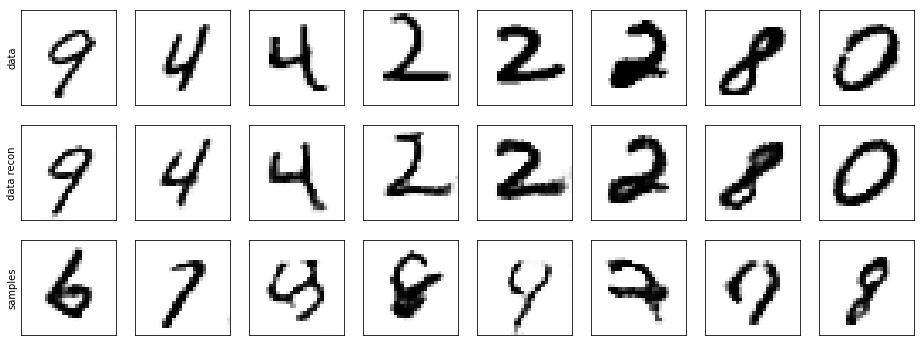

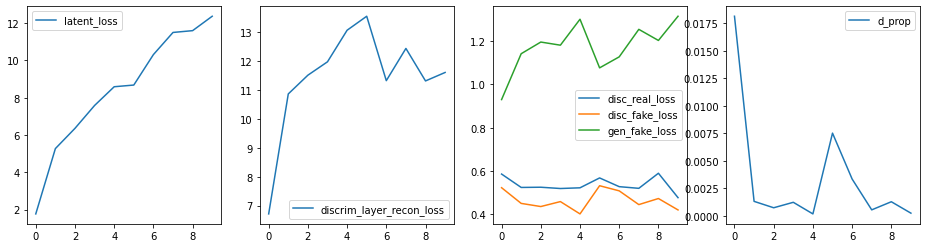

In [7]:
n_epochs = 10
for epoch in range(n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        model.train(train_x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), train_dataset), total=N_TEST_BATCHES
    ):
        loss.append(model.compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # plot results
    display.clear_output()
    print(
        "Epoch: {}".format(epoch)
    )
    plot_reconstruction(model, example_data)
    plot_losses(losses)